# KSEC3D Demo: IEC Turbulence

In this brief demo, the ksec3d module is used to generate and plot a small turbulence box according to IEC 61400-1 Ed. 3. Please note that, in order for this demo to work, you should have installed the ksec3d package according to the instructions on the repository.

In [16]:
%matplotlib inline
from ksec3d import gen_turb  # generate turbulence function
from ksec3d.core.simulation import gen_spat_grid

Let us beginning by defining our inputs to the turbulent simulation.

In [6]:
x = [-10, 10]  # x-components of turbulent grid
z = [70, 80]  # z-components of turbulent grid
T = 10  # length of turbulent simulation
dt = 0.01  # time step
kwargs = {'v_hub': 10, 'i_ref': 0.14, 'ed': 3, 'l_c': 340.2}  # necessary keyword arguments for IEC turbulence

Now we will use the built-in function to create the pandas dataframe with the necessary inputs for the turbulence generation function. This built-in function assumes that we want a turbulence box with predefined edges and all three turbulent parameters.

In [7]:
spat_df = gen_spat_grid(x, z)  # create our spatial pandas dataframe. Columns are k, x, y, and z.

And the next stage: turbulence simulation! Here, we assume the IEC coherence model, and the Kaimal power spectrum.

In [9]:
turb_df = gen_turb(spat_df,
                   coh_model='iec', spc_model='kaimal', T=T, dt=dt,
                   **kwargs)

We can plot the result easily because it is a pandas dataframe.

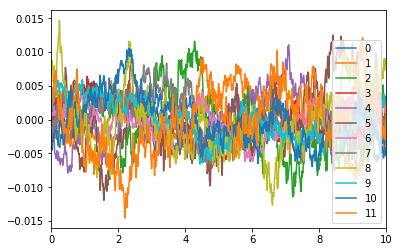

In [17]:
turb_df.plot()

Or we can check out statistics:

In [18]:
turb_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1000.000000
mean,-1.110223e-19,-2.775558e-20,0.000000,0.000000,0.000000,0.000000,1.942890e-19,-2.220446e-19,5.551115e-20,0.000000,1.110223e-19,0.000000
std,2.451916e-03,3.382885e-03,0.004625,0.002477,0.003383,0.004625,2.275226e-03,3.382883e-03,4.625040e-03,0.002810,3.382885e-03,0.004625
min,-6.217597e-03,-8.878618e-03,-0.011417,-0.006716,-0.007918,-0.011937,-6.184135e-03,-7.603165e-03,-1.265233e-02,-0.006583,-7.517002e-03,-0.014544
25%,-1.886498e-03,-2.359070e-03,-0.003590,-0.001514,-0.002421,-0.003227,-1.530695e-03,-2.658160e-03,-3.258434e-03,-0.002197,-2.388932e-03,-0.003107
50%,-1.988668e-04,-3.828539e-04,0.000248,-0.000239,-0.000143,-0.000232,1.530680e-04,-2.721558e-04,-2.583247e-04,-0.000077,-5.610202e-04,0.000202
75%,1.768063e-03,2.587836e-03,0.003193,0.001896,0.002318,0.002597,1.719737e-03,2.705295e-03,2.722476e-03,0.002253,2.129471e-03,0.003242
max,5.709025e-03,8.271227e-03,0.011589,0.006399,0.011072,0.012483,4.872763e-03,8.358502e-03,1.470923e-02,0.005914,1.051476e-02,0.012115
